##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024
### TP1 - Recherche de documents avec une métrique de similarité


## Identification de l'équipe:

### Groupe de laboratoire: G01_B1

### Equipe numéro : Eq01

### Membres:

- Zoé Paradis 2008732 (33% de contribution. nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réaliseé ensemble en combinant le code de tous les coéquipières.)
- Mahacine Ettahri 2312965 (33% de contribution. nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réaliseé ensemble en combinant le code de tous les coéquipières.)
- Xuewei Li 1879356 (33% de contribution, nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réaliseé ensemble en combinant le code de tous les coéquipières.)

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

## Mise en place

### Objectif du TP

La recherche d'information est le processus d'accès aux données, généralement des documents ou d'autres données non structurées, à partir d'une requête. Dans ce TP, vous aurez en entrée une requête textuelle sous forme d'affirmation. Il faudra retrouver dans un corpus de littérature scientifique les documents pertinents qui justifient ou infirment la véracité de cette affirmation. Vous utiliserez des modèles vectoriels et des métriques de similarité pour cette tâche.

### Jeux de données

Dans ce TP, vous utiliserez le jeu de données dans le répertoire _data_. Il s'agit d'un ensemble de données comprenant 809 affirmations rédigées par des experts et 5183 documents de références pour ces affirmations. Ces documents contiennent des phrases qui confirment ou infirment (contredisent) les affirmations. L'objectif est donc de trouver un document pertinent, c'est-à-dire contenant la ou les phrases qui permettent d'évaluer une affirmation donnée en entrée en utilisant une similarité sémantique. 

Le jeu de données comprend :

1. Un corpus (_corpus.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'doc_id' : permet d'identifier le document en entrée
    - 'title' : donne le titre du document
    - 'abstract': est le résumé du document
    - 'structured': indique si le document est structuré ou pas

2. Un ensemble d'affirmations (_claims.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'id' : identifie l'affirmation.
    - 'claim' : est l'affirmation en tant que telle.
    - 'evidence' : précise quelles phrases du document sont pertinentes pour l'affirmation. Chaque phrase est accompagnée d'une étiquette de véracité (confirm/contradict) pour indiquer si la phrase confirme ou contredit l'affirmation.  
    - 'cited_doc_ids' : indique les identifiants des documents cités.



Dans _claims.jsonl_, seuls les identifiants des documents sont renseignés. Pour avoir les détails d'un document tel que le titre ("title") et le résumé ("abstract"), il faudra consulter le fichier _corpus.jsonl_. 

Voici un exemple :

- **Affirmation (claim)** : Consumption of whole fruits increases the risk of type 2 diabetes.
- **Cited document(s) ID(s)** : 1974176
- **Evidence (sentence in the document containing the proof)** : [{'sentences': [11], 'label': 'CONTRADICT'}]

  Ici [11] constitue le numéro de la phrase qui contredit l'affirmation.

- **Cited document(s) title(s)** : Fruit consumption and risk of type 2 diabetes: results from three prospective longitudinal cohort studies
- **Cited document(s) abstract(s) (list of sentences)** : 
    - [0] 'OBJECTIVE To determine whether individual fruits are differentially associated with risk of type 2 diabetes.\n'
    - [1] 'DESIGN Prospective longitudinal cohort study.'
    - ...
    - [10] 'CONCLUSION Our findings suggest the presence of heterogeneity in the associations between individual fruit consumption and risk of type 2 diabetes.'
    - [11] 'Greater consumption of specific whole fruits, particularly blueberries, grapes, and apples, is significantly associated with a lower risk of type 2 diabetes, whereas greater consumption of fruit juice is associated with a higher risk.'

Le champ "evidence" indique la phrase au niveau du résumé du document qui confirme ou infirme l'affirmation, d'où le numéro de la phrase et le label qui y sont renseignés. Dans le cas particulier de l'exemple ci-dessus, on voit bien que la onzième phrase du résumé du document est la plus pertinente pour l'affirmation et qu'elle la contredit, ce qui explique le label "CONTRADICT" dans "evidence". Cependant, dans le cadre de ce TP, on ne s'intéresse qu'à la présence de cette phrase pertinente dans le document, donc on ne considérera pas cette colonne "evidence" dans la suite du TP.

### Librairies permises
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- PowerLaw
- Matplotlib
- TQDM
- BM25
- Pour toute autre librairie, demandez à votre chargé de laboratoire

## Étapes du TP
A partir du notebook _INF8460_A24_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Notez que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

In [63]:
# Lien vers les fichiers à utiliser
# Ne pas modifier

PATH = 'data/ai2_data/'

In [64]:
!pip install rank_bm25 
!pip install powerlaw

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [65]:
# Import des librairies

import numpy as np
import pandas as pd
import powerlaw
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Dict

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from rank_bm25 import BM25Okapi

In [66]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\XueweiLi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\XueweiLi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Traitement des données (15 points)
Vous allez effectuer une analyse afin d'avoir une idée claire des données que vous aurez à manipuler.

#### 1.1 Chargement des données (2 points)

##### 1.1.1 Chargement et affichage des données (1 point)

Chargez les données '_claims.jsonl_' et '_corpus.jsonl_' puis affichez-les dans des dataframes en utilisant panda.

In [67]:
df_claims = pd.read_json(PATH + 'claims.jsonl',lines=True)
df_corpus = pd.read_json(PATH +'corpus.jsonl',lines=True)

In [68]:
df_claims.head(10)

,id,claim,evidence,cited_doc_ids
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818]
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012]
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787]
3,6,10% of sudden infant death syndrome (SIDS) dea...,{},[2613775]
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107]
5,10,4-PBA treatment decreases endoplasmic reticulu...,{},[32587939]
6,11,4-PBA treatment raises endoplasmic reticulum s...,{},[32587939]
7,12,40mg/day dosage of folic acid and 2mg/day dosa...,"{'33409100': [{'sentences': [8], 'label': 'SUP...",[33409100]
8,14,5'-nucleotidase metabolizes 6MP.,{},[641786]
9,15,50% of patients exposed to radiation have acti...,{},[22080671]


In [69]:
df_corpus.head(10)

,doc_id,title,abstract,structured
0,4983,Microstructural development of human newborn c...,[Alterations of the architecture of cerebral w...,False
1,5836,Induction of myelodysplasia by myeloid-derived...,[Myelodysplastic syndromes (MDS) are age-depen...,False
2,7912,"BC1 RNA, the transcript from a master gene for...",[ID elements are short interspersed elements (...,False
3,18670,The DNA Methylome of Human Peripheral Blood Mo...,[DNA methylation plays an important role in bi...,False
4,19238,The human myelin basic protein gene is include...,[Two human Golli (for gene expressed in the ol...,False
5,33370,Targeting A20 Decreases Glioma Stem Cell Survi...,[Glioblastomas are deadly cancers that display...,False
6,36474,Efficient targeting of expressed and silent ge...,[Realizing the full potential of human embryon...,False
7,54440,Empirical Bayesian models for analysing molecu...,[BACKGROUND Microarrays offer great potential ...,True
8,70115,Bayesian measures of model complexity and fit,"[Summary., We consider the problem of comparin...",False
9,70490,Simplifying likelihood ratios,[Likelihood ratios are one of the best measure...,False


##### 1.1.2 Statistique sur les évidences (1 point)

Calculez les pourcentages d'apparition de chaque label des évidences dans "_df_claims_" (CONTRADICT ou SUPPORT). Pour rappel les évidences sont les extraits pertinents des résumés qui supportent ou contredisent les affirmations. 

In [70]:
# On calcule les pourcentages des labels presents dans evidence
support_count = 0
contradict_count = 0
for _ , claim in df_claims.iterrows():
    if len(claim.evidence) != 0:
        # On incrémente le compte par la longueur de la liste contenant SUPPORT ou CONTRADICT dans le label des évidences 
        support_count += len([1 for key,elements in claim.evidence.items() for element in elements if element['label'] == 'SUPPORT'])
        contradict_count += len([1 for key,elements in claim.evidence.items() for element in elements if element['label'] == 'CONTRADICT'])
        

# On divise le compte par le nombre total pour obtenir les pourcentages
total_count = support_count + contradict_count
support_percentage = support_count/total_count * 100
contradict_percentage = contradict_count/total_count * 100

print("CONTRADICT ", "{:.2f}".format(contradict_percentage), "%")
print("SUPPORT ", "{:.2f}".format(support_percentage), "%")

CONTRADICT  35.63 %
SUPPORT  64.37 %


> Réponse attendue:
> 
> CONTRADICT: 35.63%
> 
> SUPPORT: 64.37%

#### 1.2 Analyse statistique des données (7 points)

Nous allons faire une suite de transformations sur les données pour les rendre plus faciles à manipuler.

##### 1.2.1 Implémentation de la fonction "_list_to_string_" 

Nous mettons à votre disposition la fonction "_list_to_string_" qui transforme une liste de phrases en un texte en les concaténant et enlèvant tous les caractères de nouvelle ligne (`\n`) pour s'assurer que nous avons un texte complet. 

In [71]:
# On transforme la liste de phrases en un texte
def list_to_string(x):
    if isinstance(x, list):
        return ' '.join(str(i).replace("\n","").replace("  "," ") for i in x)  # Enlève les caractère de retour à la ligne et convertit les éléments de la liste en chaînes et les joint
    return str(x)

##### 1.2.2 Utilisation de la fonction "_list_to_string_" 

Appliquons cette fonction "_list_to_string_" aux colonnes "_title_" et "abstract" du dataframe "_df_corpus_".

In [72]:
# On applique la fonction aux colonnes "title" et "abstract"
df_corpus['title']    = df_corpus['title'].apply(list_to_string)
df_corpus['abstract'] = df_corpus['abstract'].apply(list_to_string)

##### 1.2.3 Ajout de la colonne "_text_" dans "df_corpus"


Ajoutons maintenant une colonne "_text_" qui est la concaténation du titre ("_title_") et du résumé ("_abstract_") au niveau du dataframe "df_corpus".

In [73]:
# On concatene les textes dans "title" et "abstract"
df_corpus['text'] = df_corpus['title'] + " " + df_corpus['abstract']

In [74]:
df_corpus

,doc_id,title,abstract,structured,text
0,4983,Microstructural development of human newborn c...,Alterations of the architecture of cerebral wh...,False,Microstructural development of human newborn c...
1,5836,Induction of myelodysplasia by myeloid-derived...,Myelodysplastic syndromes (MDS) are age-depend...,False,Induction of myelodysplasia by myeloid-derived...
2,7912,"BC1 RNA, the transcript from a master gene for...",ID elements are short interspersed elements (S...,False,"BC1 RNA, the transcript from a master gene for..."
3,18670,The DNA Methylome of Human Peripheral Blood Mo...,DNA methylation plays an important role in bio...,False,The DNA Methylome of Human Peripheral Blood Mo...
4,19238,The human myelin basic protein gene is include...,Two human Golli (for gene expressed in the oli...,False,The human myelin basic protein gene is include...
...,...,...,...,...,...
5178,195689316,Body-mass index and cause-specific mortality i...,BACKGROUND The main associations of body-mass ...,True,Body-mass index and cause-specific mortality i...
5179,195689757,Targeting metabolic remodeling in glioblastoma...,A key aberrant biological difference between t...,False,Targeting metabolic remodeling in glioblastoma...
5180,196664003,Signaling architectures that transmit unidirec...,A signaling pathway transmits information from...,False,Signaling architectures that transmit unidirec...
5181,198133135,"Association between pre-diabetes, type 2 diabe...",AIMS Trabecular bone score (TBS) is a surrogat...,True,"Association between pre-diabetes, type 2 diabe..."


##### 1.2.4 Ajout de colonnes dans "_df_claims_" (1 point)

Ajoutez les colonnes "_claim_length_" et "_num_cited_doc_" qui donnent, pour chaque affirmation, le nombre de mots dans la colonne "_claim_" et le nombre de documents cités au niveau de la colonne "_cited_doc_ids_" pour le dataframe "_df_claims_". Vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [75]:
# On calcule pour chaque affirmation le nombre de termes après avoir segmenté la phrase
df_claims['claim_length'] = df_claims['claim'].apply(lambda x: len(x.split()))
# On calcule la longueur du tableau de documents asscociés à chaque affirmation
df_claims['num_cited_doc'] = df_claims['cited_doc_ids'].apply(lambda x: len(x))

df_claims

,id,claim,evidence,cited_doc_ids,claim_length,num_cited_doc
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818],5,1
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012],10,1
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787],12,1
3,6,10% of sudden infant death syndrome (SIDS) dea...,{},[2613775],16,1
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107],13,1
...,...,...,...,...,...,...
804,1403,siRNA knockdown of A20 accelerates tumor progr...,"{'33370': [{'sentences': [6], 'label': 'CONTRA...","[33370, 38355793]",14,2
805,1404,siRNA knockdown of A20 slows tumor progression...,"{'33370': [{'sentences': [6], 'label': 'SUPPOR...","[33370, 38355793]",14,2
806,1405,taa1 tar1 tar2 triple mutants in Arabidopsis d...,{},[10504681],14,1
807,1406,β-sheet opening occurs during pleurotolysin po...,"{'2617858': [{'sentences': [4], 'label': 'SUPP...",[2617858],7,1


##### 1.2.5 Ajout des colonnes de mesures de longeurs de textes (documents) (1 point)

Ajoutez les colonnes "_title_length_", "_abstract_length_" et "_text_length_" qui donnent le nombre de mots dans les colonnes "_title_", "_abstract_" et "_text_" du dataframe "_df_corpus_". Pour le reste du TP, nous définirons la longueur du "_title_", "_abstract_" et du "_text_" comme étant le nombre de mots dans les chaînes de caractères respectives. Encore une fois, vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [76]:
# On calcule pour chaque document le nombre de termes (titres, résumés et textes) après avoir segmenté la phrase
df_corpus['title_length'] = df_corpus['title'].apply(lambda x: len(x.split()))
df_corpus['abstract_length'] = df_corpus['abstract'].apply(lambda x: len(x.split()))
df_corpus['text_length'] = df_corpus['text'].apply(lambda x: len(x.split()))

df_corpus

,doc_id,title,abstract,structured,text,title_length,abstract_length,text_length
0,4983,Microstructural development of human newborn c...,Alterations of the architecture of cerebral wh...,False,Microstructural development of human newborn c...,17,278,295
1,5836,Induction of myelodysplasia by myeloid-derived...,Myelodysplastic syndromes (MDS) are age-depend...,False,Induction of myelodysplasia by myeloid-derived...,7,201,208
2,7912,"BC1 RNA, the transcript from a master gene for...",ID elements are short interspersed elements (S...,False,"BC1 RNA, the transcript from a master gene for...",20,180,200
3,18670,The DNA Methylome of Human Peripheral Blood Mo...,DNA methylation plays an important role in bio...,False,The DNA Methylome of Human Peripheral Blood Mo...,9,238,247
4,19238,The human myelin basic protein gene is include...,Two human Golli (for gene expressed in the oli...,False,The human myelin basic protein gene is include...,21,241,262
...,...,...,...,...,...,...,...,...
5178,195689316,Body-mass index and cause-specific mortality i...,BACKGROUND The main associations of body-mass ...,True,Body-mass index and cause-specific mortality i...,15,413,428
5179,195689757,Targeting metabolic remodeling in glioblastoma...,A key aberrant biological difference between t...,False,Targeting metabolic remodeling in glioblastoma...,6,159,165
5180,196664003,Signaling architectures that transmit unidirec...,A signaling pathway transmits information from...,False,Signaling architectures that transmit unidirec...,8,246,254
5181,198133135,"Association between pre-diabetes, type 2 diabe...",AIMS Trabecular bone score (TBS) is a surrogat...,True,"Association between pre-diabetes, type 2 diabe...",14,233,247


##### 1.2.6 Analyse statistique (1.5 point)

Faites l'analyse statistique des données en affichant le "_min_", le "_max_" et la "_moyenne_" pour les deux colonnes "_claim_length_" et "_num_cited_doc_" que vous venez de créer.

In [77]:
print('claim_length')
print('min:', min(df_claims['claim_length']),' ','max:', max(df_claims['claim_length']),' ','moyenne:', df_claims['claim_length'].mean())

print('num_cited_doc')
print('min:', min(df_claims['num_cited_doc']),' ','max:', max(df_claims['num_cited_doc']),'  ','moyenne:', df_claims['num_cited_doc'].mean())

claim_length
min: 3   max: 39   moyenne: 12.332509270704573
num_cited_doc
min: 1   max: 5    moyenne: 1.1359703337453646


##### 1.2.7 Histogrammes (2 points)

En considérant le dataframe du corpus de résumés ("_df_corpus_"), affichez dans 3 histogrammes les distributions suivantes:

- Fréquence des titres ('_title_') en fonction de leur longueur
- Fréquence des résumés ('_abstract_') en fonction de leur longueur
- Fréquence des textes ('_text_') en fonction de leur longueur

Utilisez la valeur de 30 pour le paramètre "_bins_"

Text(0.5, 0, 'Longueur des textes')

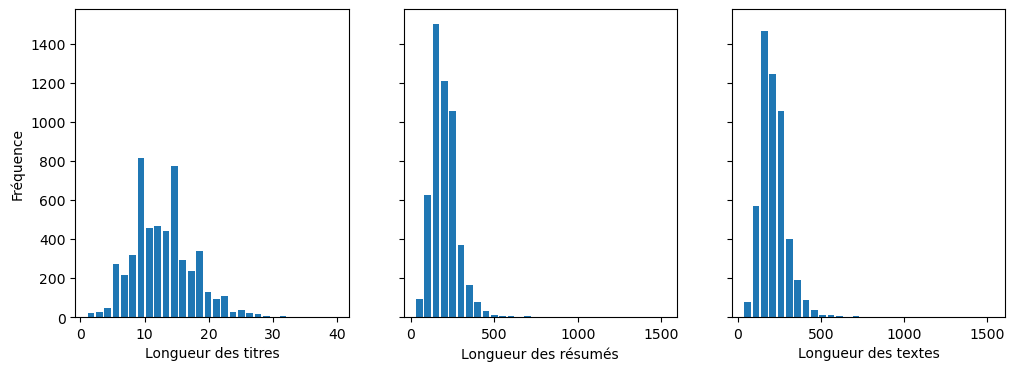

In [78]:
# On affiche les fréquences des longeurs des trois représentations des documents
fig, ax = plt.subplots(1,3,figsize=(12,4),sharey=True)
for i, j in zip([0,1,2], ['title','abstract','text']):
    ax[i].hist(df_corpus[f'{j}_length'], bins=30, rwidth=0.8)

ax[0].set_ylabel('Fréquence') 

ax[0].set_xlabel('Longueur des titres')
ax[1].set_xlabel('Longueur des résumés')
ax[2].set_xlabel('Longueur des textes')

##### 1.2.8 Quelles remarques faites-vous sur les affirmations (claims) et les documents ? (1.5 points) 

En observant les maximums, les minimums et les moyennes, que remarquez-vous à propos des affirmations ('_claims_') ? À l'aide des graphiques générés, comparez également les documents.

En observant les données concernant les affirmations (claims), nous remarquons une variabilité modérée dans la longueur des affirmations (minimum : 3 mots Vs maximum : 39 mots). La moyenne suggère que la plupart des affirmations tendent à être brèves, mais il existe des cas exceptionnels avec une longueur beaucoup plus importante. Par contre, le nombre de documents cités par affirmation varie de manière faible (un petit intervalle de 1 à 5 inclus). On remarque également que la moyenne est à peu près 1.13, ce qui veut dire que la majorité des affirmations ont entre 1 et 2 documents associés.

En observant le graphique des titres, on remarque une distribution similaire à celle des longueurs des affirmations. La plupart des titres se composent de moins de 30 mots. 

En ce qui concerne les résumés et les textes (fusion des résumés et titres), les graphiques montrent que la majorité des documents se composent de 200 à 400 mots. Ces documents sont généralement plus longs que les affirmations, car ils fournissent des informations supplémentaires par rapport à celles-ci.

#### 1.3 Pré-traitement (6 points)
Les affirmations et résumés de texte de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de document (pouvant être "_title_", "_abstract_" ou la fusion des deux représentée par "_text_") qui justifie/contredit une affirmation. Vous devez donc implémenter une étape de pré-traitement des données.

##### 1.3.1 Implémentation de la fonction "_tokenize_sentence_" (1 point)

Implémentez la fonction "_tokenize_sentence_" pour la segmentation d'une phrase en une liste de jetons. Utilisez la librarie `nltk`.

In [79]:
# On segmente d'une phrase en une liste de jetons
def tokenize_sentence (phrase):
    return word_tokenize(phrase)

In [80]:
tokenize_sentence('Jane Doe is wearing a dress.')

['Jane', 'Doe', 'is', 'wearing', 'a', 'dress', '.']

##### 1.3.2 Implémentation de la fonction "_tokenize_text_" (1 point)
Implémentez la fonction "_tokenize_text_" qui utilise "_tokenize_sentence_" pour faire la segmentation d'un texte (liste de phrases).

In [81]:
# On segmente un texte en une liste de phrases
def tokenize_text (list_phrases):
    return tokenize_sentence(' '.join(list_phrases))

In [82]:
tokenize_text(['Jane Doe is wearing a dress.', 'Tom is eating an apple'])

['Jane',
 'Doe',
 'is',
 'wearing',
 'a',
 'dress',
 '.',
 'Tom',
 'is',
 'eating',
 'an',
 'apple']

##### 1.3.3 Implémentation de la fonction "_stem_tokens_" (1 point)

Implémentez la fonction "_stem_tokens_" qui prend une liste de jetons (tokens) en entrée et retourne une liste contenant leur forme racinisée (stems) en utilisant l'algorithme de racinisation PorterStemmer de la bibliothèque nltk.

In [83]:
# On transforme les jetons en leur forme racinisée
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(i) for i in tokens]

In [84]:
stem_tokens(["sing", "singers", "singer", "singing"])

['sing', 'singer', 'singer', 'sing']

##### 1.3.4 Pré-traitement (2 points)

En utilisant vos précédentes fonctions, faites maintenant le pré-traitement des champs "_text_", "_title_" et "_abstract_" du dataframe "_df_corpus_" et "_claim_" du dataframe "_df_claims_" en suivant les étapes suivantes:
- conversion en minuscules
- segmentation (tokenization) des passages
- suppression des stop-words et ponctuation
- racinisation (stemming) des jetons

Nommez la liste des affirmations pré-traitées par "_claims_preprocessed_". Pour le corpus de documents considérez les ensembles de titres "_title_", de résumés "abstract" et la fusion des deux "_text_" et nommez les listes correspondantes par "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_" respectivement.

In [85]:
# On fait appel à l'ensemble des fonctions de prétraitement
def preprocessing(dataframe, column_name, result_list):
    for index , row in dataframe.iterrows():
        sentence = row[column_name]
        
        # conversion en minuscules
        sentence_lower = sentence.lower()
        
        # segmentation (tokenization) des passages
        tokens = tokenize_sentence(sentence_lower)
        
        # suppression des stop-words et ponctuation
        tokens_wo_stops_punctuation = [token for token in tokens if token not in stop_words and token not in punctuation]
        
        # racinisation (stemming) des jetons
        tokens_stem = stem_tokens(tokens_wo_stops_punctuation)

        result_list.append(tokens_stem)
    return result_list

In [86]:
claims_preprocessed = []
preprocessing(df_claims, 'claim', claims_preprocessed)

titles_preprocessed = []
preprocessing(df_corpus, 'title', titles_preprocessed)

abstracts_preprocessed = []
preprocessing(df_corpus, 'abstract', abstracts_preprocessed)

texts_preprocessed = []
preprocessing(df_corpus, 'text', texts_preprocessed)

print(' ')

##### 1.3.5 Jetons uniques (types) (1 point)

Affichez maintenant le nombre total de jetons dans tous les textes (_text_) et affirmations (_claim_) (en les considérant comme un seul corpus) après le pré-traitement. Puis, affichez le nombre de jetons uniques (types) dans les textes (_text_) et les affirmations (_claim_). 

In [87]:
# On calcule le nombre total de jetons dans tous les textes (text) et affirmations (claim) 
claims_list = [token for line in claims_preprocessed for token in line]
texts_list = [token for line in texts_preprocessed for token in line]

print('nombre total de jetons :', len(texts_list) + len(claims_list))

print('nombre de types:',len(set(texts_list + claims_list)))

nombre total de jetons : 742202
nombre de types: 45195


### 2. Représentation des affirmations et des documents  (45 points)

#### 2.1  Vocabulaire (15 points)

##### 2.1.1 Implémentation de la fonction "_get_vocab_" (3 points)

Implémentez la fonction "_get_vocab_" qui prend une liste de textes composés chacun d'une liste de jetons et retourne un dictionnaire dont les clés sont les jetons uniques et les valeurs sont leur fréquence dans l'ensemble des textes.

In [88]:
def get_vocab(text_list):
    # On récupère les jetons dans chaque liste de textes  
    all_tokens = [token for text in text_list for token in text] 
    # On initialise le dictionnaire de vocabulaire
    dict_tokens = dict.fromkeys(set(all_tokens),0)
    # On incrémente le compte pour chaque jeton 
    for token in all_tokens:
        dict_tokens[token]+=1
    return dict_tokens

In [89]:
texts = [['test1', 'test2'],['test3','test2','test2']]
get_vocab(texts)

{'test1': 1, 'test2': 3, 'test3': 1}

##### 2.1.2 Implémentez la fonction "_show_top_N_types_" (3 points)

Implémentez la fonction "show_top_N_types" qui affiche les N jetons les plus fréquents à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_".

La fonction prend deux arguments: le dictionnaire "_dictionary_" et le paramètre "_N_". 

In [90]:
def show_top_N_types(dict_tokens, n):
    # On ordonne les jetons par ordre décroissant de fréquence         
    tokens_sorted = sorted(dict_tokens.items(), key=lambda x: x[1], reverse = True)
    # On retourne les n premiers jetons   
    return tokens_sorted[:n]

In [91]:
show_top_N_types({'test62': 1, 'test23': 1, 'test3': 1, 'test12': 1, 'test1': 1, 'test2': 3}, 2)

[('test2', 3), ('test62', 1)]

##### 2.1.3 Construction du vocabulaire (1 point)

Construisez maintenant le vocabulaire pour les affirmations et le corpus de documents à partir des listes "texts_preprocessed" et "claims_preprocessed". 

Ensuite affichez les 15 jetons les plus fréquents ainsi que leur fréquence.

In [92]:
list_texts_claims = list(texts_preprocessed)+ list(claims_preprocessed)

print('Nombre de types composant le vocabulaire: ', len(get_vocab(list_texts_claims)))
print('Les 15 types les plus fréquents:', show_top_N_types(get_vocab(list_texts_claims),15))

Nombre de types composant le vocabulaire:  45195
Les 15 types les plus fréquents: [('cell', 10464), ('patient', 4175), ('activ', 4145), ('studi', 4014), ('use', 3799), ('express', 3626), ('result', 3213), ('protein', 3083), ('gene', 3004), ('cancer', 2945), ('increas', 2794), ('associ', 2659), ('effect', 2567), ('function', 2515), ('human', 2464)]


Sortie attendue:

```Nombre de types composant le vocabulaire: 45195
Les 15 types les plus fréquents:
('cell', 10464)
('patient', 4175)
('activ', 4145)
('studi', 4014)
('use', 3799)
('express', 3626)
('result', 3213)
('protein', 3083)
('gene', 3004)
('cancer', 2945)
('increas', 2794)
('associ', 2659)
('effect', 2567)
('function', 2515)
('human', 2464)

##### 2.1.4 Implémentation de la fonction "_show_distribution_" (4 points)

Implémentez la fonction "__show_distribution__" qui permet de visualiser la distribution des fréquences des jetons à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_", en utilisant un graphique où l'axe des abscisses représente le rang d'un type (après un tri par ordre de fréquence décroissante) et l'axe des ordonnées représente sa fréquence sur une échelle logarithmique.  

Par exemple, le point (10000, 10) voudrait dire que le 10000ème mot le plus fréquent a une fréquence à peu prés egale à 10 dans le vocabulaire.

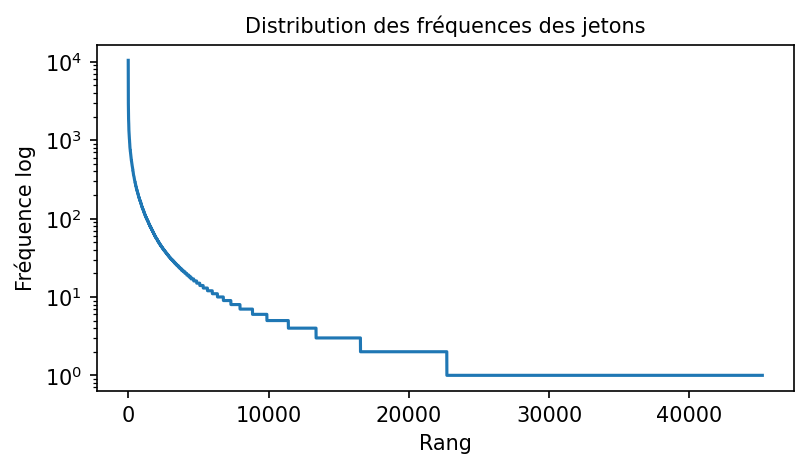

In [93]:
def show_distribution(dict_tokens):
    tokens_sorted = sorted(dict_tokens.items(), key=lambda x: x[1], reverse = True)
    
    fig, ax = plt.subplots(figsize = (6,3),dpi=150)
    
    ax.plot(range(1,len(tokens_sorted)+1),[token[1] for token in tokens_sorted])
    
    ax.set_ylabel('Fréquence log', fontsize=10)
    ax.set_yscale('log')
        
    ax.set_xlabel('Rang', fontsize=10)
    
    ax.set_title('Distribution des fréquences des jetons',fontsize=10)

show_distribution(get_vocab(list_texts_claims))

##### 2.1.5 Vérification de la loi de Zipf (4 points)

Afin de vérifier la loi de Zipf, donnez une estimation de la valeur de la constante k de cette loi définie comme suit: 

$$ f \approx \frac{k}{r^\alpha} $$ 

où $ f $ est la fréquence d'un mot, $ r $ est le rang de ce mot dans la liste triée par fréquence décroissante, et $ k $ est une constante. Etant données les fluctuations sur les valeurs de fréquence, vous pouvez utiliser la librairie ['powerlaw'](https://pypi.org/project/powerlaw/) conçue pour analyser et ajuster des distributions de loi de puissance aux données et qui peut être utile dans l'estimation de $ \alpha $.

Affichez la constante $ k $ trouvée, les fréquences réelles des mots avec celles qui sont prédites par la loi de Zipf.

In [94]:
# On récupère et ordonne les jetons 
dict_tokens = get_vocab(list_texts_claims)
tokens_sorted = sorted(dict_tokens.items(), key=lambda x: x[1], reverse = True)

# On récupère les fréquences ordonnées et les rangs correspondants
frequency = [token[1] for token in tokens_sorted]
rank = np.arange(1,len(tokens_sorted)+1)

fit = powerlaw.Fit(frequency)

# On calcule alpha
alpha = fit.alpha
print(alpha)

Calculating best minimal value for power law fit
1.7774914193011577


constante k: 66781392.86948402


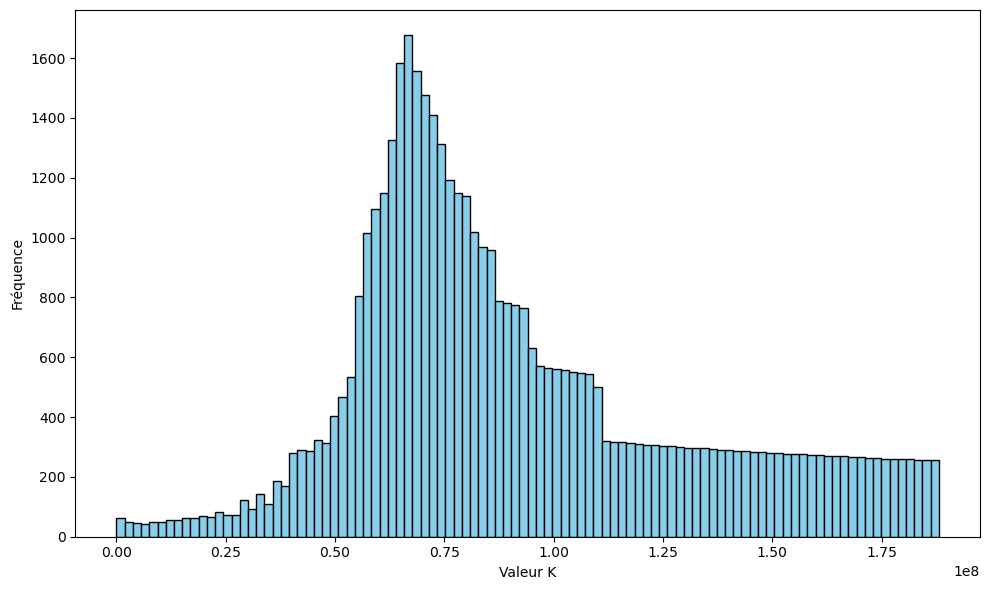

In [95]:
# On visualise la distribution des produits f * r^alpha pour trouver le meilleur K
k_list = []
for r in rank:
    # On calcule k = f * r^alpha
    k = frequency[r-1] * (r)**alpha
    k_list.append(k)

plt.figure(figsize=(10, 6))
frequencies, bins, patches = plt.hist(k_list, bins=100, color='skyblue', edgecolor='black')

# On récupère l'intervalle des produits f * r^alpha les plus fréquents
max_frequency = np.max(frequencies)
max_index = np.argmax(frequencies)
corresponding_bin = (bins[max_index], bins[max_index + 1])

# On définit k en étant la moyenne sur l'intervalle récupéré
print('constante k:', np.mean(corresponding_bin))

plt.xlabel('Valeur K')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

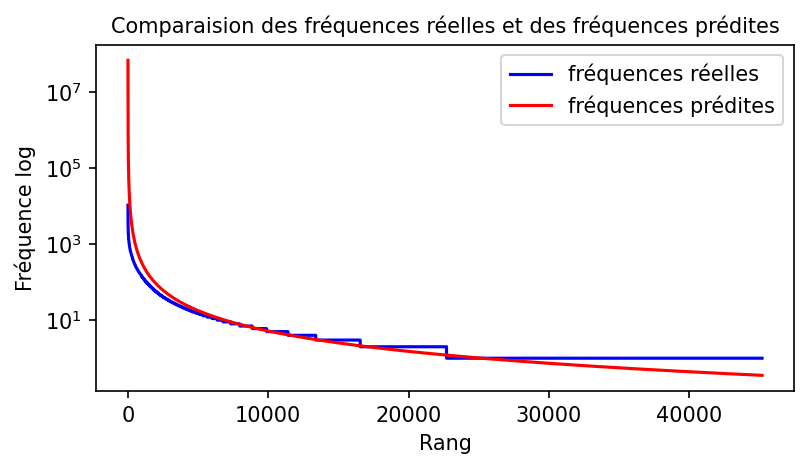

In [96]:
# On définit k en étant la moyenne sur l'intervalle récupéré
k = np.mean(corresponding_bin)
predicted_frequency_list = []

for r in rank:
    # On calcule les fréquences prédites
    predicted_frequency = k * ((r)**(-alpha))
    predicted_frequency_list.append(predicted_frequency)


def show_distribution(dict_tokens):
    tokens_sorted = sorted(dict_tokens.items(), key=lambda x: x[1], reverse = True)
    
    fig, ax = plt.subplots(figsize = (6,3),dpi=150)
    
    ax.plot(range(1,len(tokens_sorted)+1),[token[1] for token in tokens_sorted], label = 'fréquences réelles', c = 'b')
    ax.plot(range(1,len(tokens_sorted)+1),predicted_frequency_list, label = 'fréquences prédites', c = 'r')
    
    ax.set_ylabel('Fréquence log', fontsize=10)
    ax.set_yscale('log')
        
    ax.set_xlabel('Rang', fontsize=10)
    
    ax.set_title('Comparaision des fréquences réelles et des fréquences prédites',fontsize=10)
    ax.legend()

show_distribution(get_vocab(list_texts_claims))





















































































#### 2.2  Création d’un modèle sac de mots (10 points)

##### 2.2.1 Répresentation de texte (5 points)

En utilisant sklearn et à partir de vos données pré-traitées ("_claims_preprocessed_", "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_"), représentez chaque affirmation (_claim_) et document avec le vocabulaire créé 'précédemment dans la variables "_claims_preprocessed_joined_", "_titles_preprocessed_joined_", "_abstract_preprocessed_joined_" et "_texts_preprocessed_joined_". Cela veut dire que tout jeton qui n'est pas dans le vocabulaire doit être enlevé dans le document et l'affirmation. Faites cela pour les trois possibilités de représentation de document: "_title_", "_abstract_" et "_text_".

In [97]:
claims_preprocessed = list(claims_preprocessed)
texts_preprocessed =list(texts_preprocessed)
titles_preprocessed = list(titles_preprocessed)
abstracts_preprocessed = list(abstracts_preprocessed)

# On filtre les jetons qui n'existent pas dans le vocabulaire
def filtration(preprocessed):
    preprocessed_joined = []
    for line in preprocessed:
        line_joined = [token for token in line if token in dict_tokens]
        preprocessed_joined.append(' '.join(line_joined))
    return preprocessed_joined

claims_preprocessed_joined = filtration(claims_preprocessed)
titles_preprocessed_joined = filtration(titles_preprocessed)
abstracts_preprocessed_joined = filtration(abstracts_preprocessed)
texts_preprocessed_joined = filtration(texts_preprocessed)

##### 2.2.2 Pondération (4 points)

En utilisant un modèle sac de mots basé sur des unigrammes et des bigrammes, créez une représentation vectorielle de vos documents (titles, abstracts, texts) et de vos affirmations (claims) avec TF-IDF en utilisant le TfidfVectorizer de sklearn. 

In [98]:
# On entraîne un modèle sac de mots basé sur des unigrammes et des bigrammes basé sur tous les documents et affirmations
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(claims_preprocessed_joined + texts_preprocessed_joined + titles_preprocessed_joined + abstracts_preprocessed_joined)

TfidfVectorizer(ngram_range=(1, 2))

##### 2.2.3 Affichage (1 point)

Affichez les dimensions (shape) de vos corpus (claims, text, title, abstract) après vectorisation

In [99]:
# On transforme le affirmations en représentation verctorielle en utilisant le modèle entraîné
claims_vector = vectorizer.transform(claims_preprocessed_joined)
claims_vector.shape

(809, 473643)

Sortie attendue pour "_claims_"
```
(809, 473643)
```

In [100]:
texts_vector = vectorizer.transform(texts_preprocessed_joined)
texts_vector.shape

(5183, 473643)

Sortie attendue pour "_texts_"
```
(5183, 473643)
```

In [101]:
titles_vector = vectorizer.transform(titles_preprocessed_joined)
titles_vector.shape

(5183, 473643)

Sortie attendue pour "_titles_"
```
(5183, 473643)
```

In [102]:
abstracts_vector = vectorizer.transform(abstracts_preprocessed_joined)
abstracts_vector.shape

(5183, 473643)

Sortie attendue pour abstracts
```
(5183, 473643)

#### 2.3 Pertinence d'un document (20 points)

Maintenant que vous avez une représentation de vos affirmations "_claims_" et documents ("_texts_", "_titles_", "_abstracts_"), il faut être capable de déterminer quel document sera le plus pertinent pour une affirmation donnée.

##### 2.3.1 Implémentation de "_eval_similarity_" (3 points)

Implémentez la fonction "_eval_similarity_" pour évaluer la similarité cosinus entre la représentation de l'affirmation et celle de chaque document. La fonction prend une liste d'affirmations et une liste de documents et retourne une matrice où chaque ligne représente une affirmation et chaque colonne représente un document ("title", "abstract" ou "text") et les valeurs sont les similarités cosinus entre une affirmation et un document.

In [103]:
# On évalue la similarité cosinus entre la représentation de chaque affirmation et celle de chaque document
def eval_similarity(claims_vector, docs_vector):
    return cosine_similarity(claims_vector, docs_vector)

similarity_texts = eval_similarity(claims_vector,texts_vector)
similarity_titles = eval_similarity(claims_vector,titles_vector)
similarity_abstracts = eval_similarity(claims_vector,abstracts_vector)

##### 2.3.2 Implémentation de la fonction "_rank_texts_" (2 points)

Implémentez la fonction "_rank_texts_", qui, au moyen de la précédente (_eval_similarity_), retourne le top-N (N=1,3,5) des documents pertinents pour une affirmation donnée (N est un paramètre). Ces documents devront être ordonnés du plus pertinent au moins pertinent. Idéalement, le document à la position 1 sera celui qui contient la preuve (ou justification) de l'affirmation. Il faudra retourner non pas les indices des documents dans le dataframe mais plutôt leur identifiants au niveau de la colonne "_doc_id_".

In [104]:
def rank_texts(matrix_similarity,top_n):
    results = []
    # Pour chaque ligne (affirmation) on récupère les mesures de similarité classées par ordre décroissant     
    for line in matrix_similarity:
        dict_rank = dict(zip(df_corpus['doc_id'], line))
        sorted_rank = sorted(dict_rank.items(), key=lambda x: x[1], reverse=True)
        # On récupère les top_n docs_id      
        results.append([i[0] for i in sorted_rank[:top_n]])
    return results

##### 2.3.3 Préparation des dataframes de réponses (1 point) 

Vous allez écrire la fonction "prepare_results_df" qui crée les dataframes qui vont contenir les résultats de la recherche de documents pertinents pour les affirmations.

La fonction "prepare_results_df" prend les arguments suivants:

- '_df_': le dataframe original nommé '_df_claims_' à partir duquel on crée les autres, 
- '_columns_to_drop_': les colonnes à supprimer 
- '_column_to_rename_': le nom de la colonne de référence dans le dataframe original qui sera renommée "gold standard passage"

et effectue les opérations suivantes:

1. Créer un nouveau dataframe à partir de "_df_claims_" en supprimant toutes les colonnes sauf "cited_doc_ids".
2. Renommer la colonne "cited_doc_ids" en "gold standard passage".
3. Ajouter les colonnes "top_1", "top_3", et "top_5" au dataframe, 
en les initialisant avec des chaînes de zéros séparés par des points-
virgules, correspondant respectivement à des configurations de 1, 3, et 
5 zéros pour toutes les lignes.

Vous utiliserez ensuite cette fonction pour créer les dataframes "results_titles_df", "results_abstracts_df" et "results_texts_df", qui seront destinés à contenir les résultats de recherche de documents pour "title", "abstract" et "text" respectivement.

In [105]:
def prepare_results_df(df, columns_to_drop, column_to_rename):

    # On crée un nouveau dataframe à partir de df en supprimant les colonnes "columns_to_drop"
    df_new = df.drop(columns=columns_to_drop).copy()
    
    # On renomme la colonne "column_to_rename" en "gold standard passage"
    df_new = df_new.rename(columns={column_to_rename: 'gold standard passage'})
    
    # On ajoute les colonnes "top_1", "top_3", et "top_5" au dataframe
    df_new['top_1'] = '0'
    df_new['top_3'] = '0;0;0'
    df_new['top_5'] = '0;0;0;0;0'
    return df_new

columns_to_drop = [column for column in df_claims if (column != 'cited_doc_ids' and column != 'id')]
df_template = prepare_results_df(df_claims, columns_to_drop, 'cited_doc_ids')

df_template.head(5)

,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],0,0;0;0,0;0;0;0;0
1,2,[13734012],0,0;0;0,0;0;0;0;0
2,4,[22942787],0,0;0;0,0;0;0;0;0
3,6,[2613775],0,0;0;0,0;0;0;0;0
4,9,[44265107],0,0;0;0,0;0;0;0;0


> Sortie attendue pour chaque dataframe préparé
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>id</th>
      <th>gold standard passage</th>
      <th>top_1</th>
      <th>top_3</th>
      <th>top_5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>[31715818]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>[13734012]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>4</td>
      <td>[22942787]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
  </tbody>
</table>
</div>

##### 2.3.4 Implémentation de la fonction "_fill_results_" (2 points)

Vous devez maintenant implémenter la fonction "_fill_results_" qui remplit les dataframes préparés dans l'étape précédente en utilisant les resultats de recherche de document.
Cette fonction prend les arguments suivant: 
- "_results_" : matrice contenant les valeurs de similarite des affirmations et des documents
- "_results_texts_df_" : Dataframe contenant les affirmations ainsi que les colonnes "top_1", "top_3", "top_5" où doivent être mis les top-n documents les plus pertinents.

Les deux arguments contiennent le même nombre d'éléments et pour le même indice, font référence à la même affirmation.

In [106]:
#  On remplit le dataframe en utilisant les resultats de recherche de document
def fill_results(results, results_texts_df):
    for j in [1,3,5]:
        results_texts_df[f'top_{j}'] = results[j]
    return results_texts_df

##### 2.3.5 Exécution des fonctions "_rank_texts_" et fill_results(2 points)

Exécutez maintenant votre fonction "_rank_texts_" sur toutes les affirmations (claims) et toutes les représentations de documents (title, abstract, text) en mettant les résultats dans les variables "results_texts", "results_titles" et "results_abstracts". Ensuite appelez la fonction "_fill_results_" qui remplit les dataframes "_results_titles_df_", "_results_abstracts_df_", et "_results_texts_df_" contenant les résultats de recheche de documents.

In [107]:
results_texts = {}
results_titles = {}
results_abstracts = {}

for j in [1,3,5]:
    results_titles[j] = [';'.join(map(str, rank)) for rank in rank_texts(similarity_titles, j)]
    results_abstracts[j] = [';'.join(map(str, rank)) for rank in rank_texts(similarity_abstracts, j)]
    results_texts[j] = [';'.join(map(str, rank)) for rank in rank_texts(similarity_texts, j)]

    
results_titles_df = fill_results(results_titles, df_template.copy())
results_abstracts_df = fill_results(results_abstracts, df_template.copy())
results_texts_df = fill_results(results_texts, df_template.copy())

In [108]:
results_texts_df.head(5)

,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],10608397,10608397;42421723;10607877,10608397;42421723;10607877;21257564;35008773
1,2,[13734012],13734012,13734012;17333231;13770184,13734012;17333231;13770184;42240424;3716075
2,4,[22942787],7165938,7165938;1387104;10958594,7165938;1387104;10958594;520579;52188256
3,6,[2613775],23117378,23117378;2613775;21050357,23117378;2613775;21050357;20240998;35521287
4,9,[44265107],44265107,44265107;24700152;14647747,44265107;24700152;14647747;26105746;32787042


##### 2.3.6 Enregistrement des dataframes 

On enregistre les dataframes dans des fichiers .csv.

In [109]:
results_texts_df.to_csv('results_texts_df.csv')
results_titles_df.to_csv('results_titles_df.csv')
results_abstracts_df.to_csv('results_abstracts_df.csv')

##### 2.3.7 Implémentation de la fonction "_show_top_n_passages_" (3 points)

Vous devez maintenant implémenter une fonction "_show_top_n_passages_" qui affiche le top-n ainsi que le texte (document) attendu pour une affirmation donnée. Ici on considère que document est representé par "_text_" donc la fusion du titre ("_title_") et du résumé ("_abstract_")

In [110]:
def show_top_n_passages(claim_id,top_n):
    print(f'**** Documents Top{top_n} ****')
    # On récupère les top_n 'doc_id' pour l'affirmation donnée     
    top_n_passages_id = results_texts_df.loc[results_texts_df['id']==claim_id][f'top_{top_n}'].values[0].split(';')
    result_top5 = {}
    # On récupère le contenu correspondant au 'doc_id'
    for top_n_id in top_n_passages_id:
        result_top5[top_n_id] = df_corpus.loc[df_corpus['doc_id']==int(top_n_id), 'text'].values[0]
    print(result_top5)
    
    print('**** Documents attendus ****')
    result_expected = {}
    # On récupère les 'doc_id' des documents attendus pour l'affirmation donnée 
    docs_expected_ids = results_texts_df[results_texts_df['id']==claim_id]['gold standard passage'].values[0]
    for expected_id in docs_expected_ids:
        result_expected[expected_id] = df_corpus.loc[df_corpus['doc_id']==expected_id, 'text'].values[0]
    print(result_expected)

##### 2.3.8 Affichage (1 point)

Appliquez cette fonction sur l'affirmation ayant pour identifiant 211 et affichez le top-5 des documents les plus pertinents retrouvés.

In [111]:
results_texts_df.loc[results_texts_df['id']==211]

,id,gold standard passage,top_1,top_3,top_5
125,211,[13794374],14019636,14019636;44737533;6290112,14019636;44737533;6290112;20261352;5137019


In [112]:
show_top_n_passages(211,5)

**** Documents Top5 ****
{'14019636': 'Ribosomal DNA copy number loss and sequence variation in cancer Ribosomal DNA is one of the most variable regions in the human genome with respect to copy number. Despite the importance of rDNA for cellular function, we know virtually nothing about what governs its copy number, stability, and sequence in the mammalian genome due to challenges associated with mapping and analysis. We applied computational and droplet digital PCR approaches to measure rDNA copy number in normal and cancer states in human and mouse genomes. We find that copy number and sequence can change in cancer genomes. Counterintuitively, human cancer genomes show a loss of copies, accompanied by global copy number co-variation. The sequence can also be more variable in the cancer genome. Cancer genomes with lower copies have mutational evidence of mTOR hyperactivity. The PTEN phosphatase is a tumor suppressor that is critical for genome stability and a negative regulator of the

##### 2.3.9 Évaluation (3 points)

Vous devez maintenant implémenter la fonction "_evaluate_" qui, à partir des colonnes *Gold standard passage* et de vos top-N respectifs, calcule la précision top-N (N=1,3,5) sur l’ensemble de données en paramètre et l’affiche. 

Cette précision connue sous le nom "precision at k (precision@k)" se calcule de la manière suivante:


$$
\text{precision@k} = \frac{\text{nombre d'éléments corrects}}{\text{nombre total d'éléments k retrouvés}}
$$


Veillez à ce que la fonction soit générique. 

In [113]:
def evaluate(df, top_n):
    # On combine les doc_id des documents attendus et ceux des top_n documents trouvés     
    combine = df['gold standard passage'] + df[f'top_{top_n}'].apply(lambda x : x.split(';'))
    # On calcule la différence de longueur entre la liste combinée et la set après avoir supprimé les doublons
    # Ceci permet de trouver le nombre de documents en commun
    nbr_correct = combine.apply(lambda x: len(x) - len(set([str(i) for i in x]))).sum()
    nbr_total = top_n * len(df[f'top_{top_n}'])
    return nbr_correct/nbr_total

In [114]:
evaluate(results_texts_df, 3)

0.22661722290894107

##### 2.3.10 Affichage (1 point)

Appliquez cette fonction pour calculer la précision des documents retrouvés en utilisant les titres ("_title_"), les résumés ("_abstract_") et la fusion des deux ("_text_").

In [115]:
print('Précision_titres :')
for j in [1, 3, 5]:
    print(f'top_{j} : ', evaluate(results_titles_df, j))
print('\n')

print('Précision_résumés :')
for j in [1, 3, 5]:
    print(f'top_{j} : ', evaluate(results_abstracts_df, j))
print('\n')

print('Précision_texts :')
for j in [1, 3, 5]:
    print(f'top_{j} : ', evaluate(results_texts_df, j))

Précision_titres :
top_1 :  0.32138442521631644
top_3 :  0.16522455706633704
top_5 :  0.1107540173053152


Précision_résumés :
top_1 :  0.46600741656365885
top_3 :  0.21714050267820353
top_5 :  0.14511742892459828


Précision_texts :
top_1 :  0.48702101359703337
top_3 :  0.22661722290894107
top_5 :  0.1515451174289246


##### 2.3.11 Graphique (2 points)

Tracez un graphique des valeurs de précisions des documents retrouvés ("__title__", "__abstract__", "__text__") pour différents N (1,3,5).

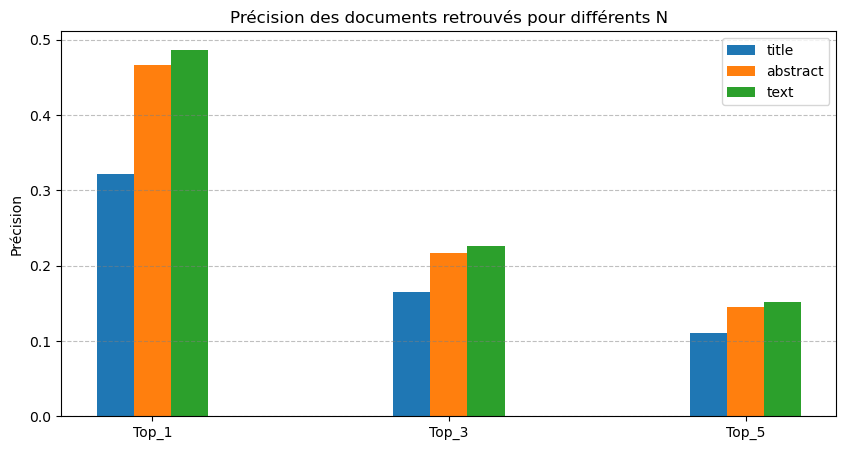

In [116]:
# On calcule les précisions pour chacune des trois représentations
precisions_tf_idf = {
    'title': [evaluate(results_titles_df, j) for j in [1, 3, 5]],
    'abstract': [evaluate(results_abstracts_df, j) for j in [1, 3, 5]],
    'text': [evaluate(results_texts_df, j) for j in [1, 3, 5]]
}

n_values = [1, 3, 5]
doc_types = ['title', 'abstract', 'text']

fig, ax = plt.subplots(figsize=(10, 5))

width = 0.25
bar_positions = {
    'title': [i - width for i in n_values],
    'abstract': n_values,
    'text': [i + width for i in n_values]
}

for doc_type in doc_types:
    ax.bar(bar_positions[doc_type], precisions_tf_idf[doc_type], width=width, label=doc_type)

ax.set_ylabel('Précision')
ax.set_title('Précision des documents retrouvés pour différents N')
ax.set_xticks(n_values)
ax.set_xticklabels(['Top_1', 'Top_3', 'Top_5'])
ax.legend()
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)

plt.show()

### 3 Amélioration avec BM25 (20 points)

BM25 (Best Matching 25) est un algorithme de recherche utilisé pour évaluer la pertinence des documents par rapport à une requête. Basé sur le modèle de récupération d'informations probabilistes, BM25 calcule un score de pertinence en tenant compte de la fréquence des termes de la requête dans chaque document et dans le corpus global mais aussi de la longueur des documents. 

BM25 est pertinent pour la recherche d'information car il offre un bon équilibre entre précision et rappel, il gère efficacement de grandes collections de documents et permet des ajustements pour différents types de corpus. Il est largement utilisé dans les moteurs de recherche et les systèmes de recommandation.

Dans cette partie on vous demande de la tester au moyen de la librairie rank_bm25 pour cette tâche de recherche de texte qui justifie ou contredit une affirmation donnée. Vous allez utiliser le corpus et les affirmations et procéder comme indiqué dans la suite.

##### 3.1 Initialisation du modèle BM25 (3 points)
Réutilisez les variables "claims_preprocessed_joined", "texts_preprocessed_joined", "titles_preprocessed_joined" et "abstract_preprocessed_joined" définies à la question `2.2.1` pour initialiser les modèles BM25 pour les documents ("__titles__", "__abstracts__" et "__text__"). Il faudra transformer chaque séquence (dont les jetons étaient joints pour former une seule chaîne) en une liste de jetons. Vous utiliserez la classe "_BM250kapi_" à ce niveau. 

In [117]:
# On initialise les modèles BM25 pour les représentations des documents
titles_bm25 = BM25Okapi([title.split(" ") for title in titles_preprocessed_joined])
abstracts_bm25 = BM25Okapi([abstract.split(" ") for abstract in abstracts_preprocessed_joined])
texts_bm25 = BM25Okapi([text.split(" ") for text in texts_preprocessed_joined])

claims_query = [claim.split(" ") for claim in claims_preprocessed_joined]

##### 3.2 Utilisation du modèle BM25 (5 points)

Retrouvez les identifiants des documents pour les cinq meilleures correspondances de "_title_", de "_abstract_" et de "_text_" en utilisant le score BM25 pour chaque affirmation (claim) traitée, et mettez à jour les résultats avec les identifiants de documents correspondants.

In [118]:
dict_titles = {}
dict_abstracts = {}
dict_texts = {}

# On récupère les top_n documents pour chaque affirmation
for idx, claim in enumerate(claims_query):
    dict_titles[idx] = titles_bm25.get_top_n(claim, titles_preprocessed_joined, n=5)
    dict_abstracts[idx] = abstracts_bm25.get_top_n(claim, abstracts_preprocessed_joined, n=5)
    dict_texts[idx] = texts_bm25.get_top_n(claim, texts_preprocessed_joined, n=5)

# On récupère les doc_id pour les documents récupérés
def find_top_n_docs(dict_doc, doc_preprocessed_joined,top_n):
    for i in dict_doc:
        doc = [d for d in dict_doc[i]]
        matching_rows = []
        for j in range(top_n):
            matching_rows.append(df_corpus.iloc[doc_preprocessed_joined.index(doc[j])]['doc_id'])
        dict_doc[i] = matching_rows
    return dict_doc

find_top_n_docs(dict_titles, titles_preprocessed_joined,5)
find_top_n_docs(dict_abstracts, abstracts_preprocessed_joined,5)
find_top_n_docs(dict_texts, texts_preprocessed_joined,5)

df_top5_bm25 = df_template.copy()
df_top5_bm25 = df_top5_bm25.drop(columns=['top_1','top_3','top_5'])

df_top5_bm25['top_5_titles'] = [';'.join(map(str, values)) for values in dict_titles.values()]
df_top5_bm25['top_5_abstracts'] = [';'.join(map(str, values)) for values in dict_abstracts.values()]
df_top5_bm25['top_5_texts'] = [';'.join(map(str, values)) for values in dict_texts.values()]

df_top5_bm25.head(5)

,id,gold standard passage,top_5_titles,top_5_abstracts,top_5_texts
0,0,[31715818],16532419;25602549;42421723;14831629;34935825,26071782;21257564;825728;28138927;26731863,26071782;21257564;18953920;26731863;825728
1,2,[13734012],32481310;4828631;103007;1583134;3870062,13734012;18617259;42240424;17333231;21616324,13734012;18617259;4828631;42240424;17333231
2,4,[22942787],24980622;10958594;39903312;31616203;12074066,1387104;24980622;10958594;5641851;13030852,10958594;24980622;1387104;5641851;13030852
3,6,[2613775],2613775;23117378;21050357;7711685;39381118,23117378;2613775;20240998;35521287;21050357,23117378;2613775;35521287;20240998;21050357
4,9,[44265107],44265107;24700152;9056874;8190282;14647747,44265107;25182647;24700152;21186109;16737210,44265107;25182647;24700152;21186109;14647747


##### 3.3 Affichage des performances (4 points)

Affichez les résultats des performances BM25 pour les configurations Top1, Top3 et Top5 avec "_title_", "_asbtract_" et "_text_".

In [119]:
df_bm25_titles = df_template.copy()
df_bm25_abstracts = df_template.copy()
df_bm25_texts = df_template.copy()

for j in [1,3,5]:
    df_bm25_titles[f'top_{j}'] = [';'.join(map(str, values[:j])) for values in dict_titles.values()]
    df_bm25_abstracts[f'top_{j}'] = [';'.join(map(str, values[:j])) for values in dict_abstracts.values()]
    df_bm25_texts[f'top_{j}'] = [';'.join(map(str, values[:j])) for values in dict_texts.values()]

df_bm25_texts.head(5)

,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],26071782,26071782;21257564;18953920,26071782;21257564;18953920;26731863;825728
1,2,[13734012],13734012,13734012;18617259;4828631,13734012;18617259;4828631;42240424;17333231
2,4,[22942787],10958594,10958594;24980622;1387104,10958594;24980622;1387104;5641851;13030852
3,6,[2613775],23117378,23117378;2613775;35521287,23117378;2613775;35521287;20240998;21050357
4,9,[44265107],44265107,44265107;25182647;24700152,44265107;25182647;24700152;21186109;14647747


##### 3.4 Graphique (4 points)

Dans un même graphique, affichez les performances pour les deux modèles (TF-IDF et BM25) dans la recherche des documents (text, title et abstract) pour les affirmations.

In [120]:
# On calcule les précisions en utilisant le modèle BM25
precisions_bm25 = {
    'title': [evaluate(df_bm25_titles, j) for j in [1, 3, 5]],
    'abstract': [evaluate(df_bm25_abstracts, j) for j in [1, 3, 5]],
    'text': [evaluate(df_bm25_texts, j) for j in [1, 3, 5]]
}

precisions_bm25

{'title': [0.32509270704573545, 0.14709517923362175, 0.09913473423980222],
 'abstract': [0.553770086526576, 0.23444581788215904, 0.15673671199011124],
 'text': [0.5673671199011124, 0.23939019365471775, 0.15822002472187885]}

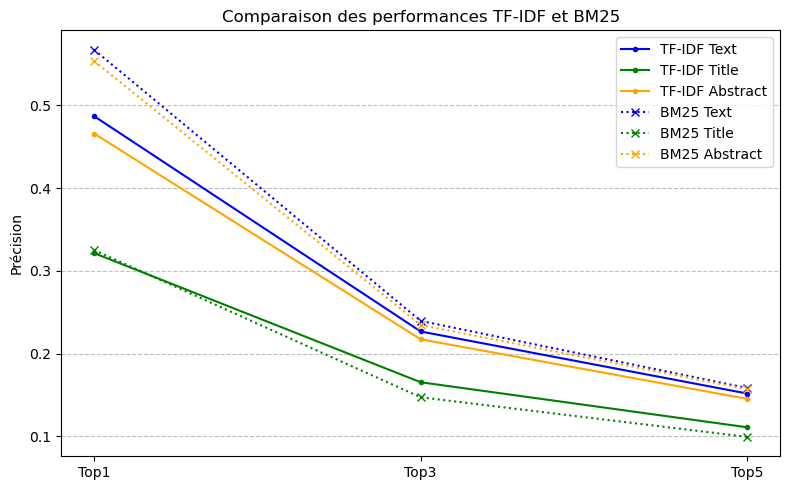

In [121]:
categories = ['text', 'title', 'abstract']
top_n = [1, 3, 5]
colors = ['blue', 'green', 'orange']
fig, ax = plt.subplots(figsize=(8, 5))


for category, color in zip(categories, colors):
    ax.plot(top_n, precisions_tf_idf[category], marker='.', color=color, linestyle='-', label=f'TF-IDF {category.capitalize()}')


for category, color in zip(categories, colors):
    ax.plot(top_n, precisions_bm25[category], marker='x', color=color, linestyle=':', label=f'BM25 {category.capitalize()}')


ax.set_ylabel('Précision')
ax.set_title('Comparaison des performances TF-IDF et BM25')
ax.set_xticks(top_n)
ax.set_xticklabels(['Top1', 'Top3', 'Top5'])
ax.legend(loc='best')
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

##### 3.5 Observation (4 points)

Par rapport à vos résultats avec TF-IDF, observez-vous une amélioration ou une détérioration des performances, qu'est ce qui explique cela ? (Donnez au moins trois justifications)

Pour les précisions des résumés et textes, on observe une amélioration importante pour les trois cas (top_1, top_3 et top_5). On a par exemple une augmentation d’à peu près 0.1 pour le top_1 des résumés.
Pour les précisions des titres, on remarque une augmentation légère pour le top_1, mais une détérioration plus prononcée pour les top 3 et 5.

La métrique BM25 règle les problèmes de TF-IDF, notamment : 

- Le biais lié à la fréquence d'un terme : Cet ajustement permet une évaluation plus raffinée de l’importance des termes dans les documents. La longueur des textes et résumés varie énormément (selon les histogrammes, elle varie entre 50 et plus de 750 termes). TF-IDF va donc favoriser les documents plus longs en raison de leur fréquence de termes. BM-25 va corriger ce biais en favorisant plutôt les documents contenant des termes de la requête (une affirmation dans notre cas) plutôt que de se baser sur la longueur uniquement. 

- La non-considération de la longueur des documents : En prenant en compte la longueur du document, BM25 peut fournir des scores de pertinence plus précis, en particulier pour les documents plus longs. C'est le cas pour les résumés et textes qui contiennent des documents relativement longs. Et c'est la raison pour laquelle les précisions fournies par BM-25 sont meilleures dans les 3 top_n. 

- BM25 comprend des paramètres (k et b) qui permettent d'optimiser la fonction de score en fonction des caractéristiques du corpus. Cela rend BM25 plus flexible et capable de s'adapter à différents types de documents, offrant ainsi des performances généralement supérieures par rapport à TF-IDF.

Pour les titres, puisqu'ils sont relativement courts (Si on se réfère aux histogrammes précédents, le nombre de terme maximal dans un titre dépasse légèrement 30 termes), donc il n'existe pas une différence flagrante entre les résultats de BM25 et TF-IDF (La détérioration dans BM-25 n'est pas aussi importante que les amélioration). La fréquence d'un terme est moins susceptible de varier dans les documents courts, et l'impact du paramètre b dans BM25 est réduit (par exemple, pour le top N document retrouvé en utilisant les titres).

## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs
